In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. 解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


file_path = r'D:\学习类文档\Data analysis\IBM员工离职预测与分析(python)\WA_Fn-UseC_-HR-Employee-Attrition.csv' 

try:
    df = pd.read_csv(file_path)
    print("✅ 第一步成功：数据已读入内存！")
    display(df.head(2))
except Exception as e:
    print(f"❌ 报错了：找不到文件，请检查路径。错误信息: {e}")

✅ 第一步成功：数据已读入内存！


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7


In [8]:
# 选择我们关心的 10 个核心列
core_columns = [
    'Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 
    'JobSatisfaction', 'MonthlyIncome', 'OverTime', 
    'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany'
]
df_clean = df[core_columns].copy()

# 翻译列名
chinese_columns = {
    'Age': '年龄', 'Attrition': '是否离职', 'BusinessTravel': '出差频率', 
    'DistanceFromHome': '通勤距离', 'JobSatisfaction': '工作满意度', 
    'MonthlyIncome': '月收入', 'OverTime': '是否加班', 
    'TotalWorkingYears': '总工龄', 'WorkLifeBalance': '工作生活平衡', 
    'YearsAtCompany': '在司年限'
}
df_clean.rename(columns=chinese_columns, inplace=True)

# 把“Yes/No”换成数字 1/0
df_clean['是否离职'] = df_clean['是否离职'].map({'Yes': 1, 'No': 0})
# 把“是否加班”也换成数字 1/0 (这对预测很重要)
df_clean['是否加班'] = df_clean['是否加班'].map({'Yes': 1, 'No': 0})

print("✅ 第二步成功：数据已经洗干净了！")
display(df_clean.head(2))

✅ 第二步成功：数据已经洗干净了！


,年龄,是否离职,出差频率,通勤距离,工作满意度,月收入,是否加班,总工龄,工作生活平衡,在司年限
0,41,1,Travel_Rarely,1,4,5993,1,8,1,6
1,49,0,Travel_Frequently,8,2,5130,0,10,3,10


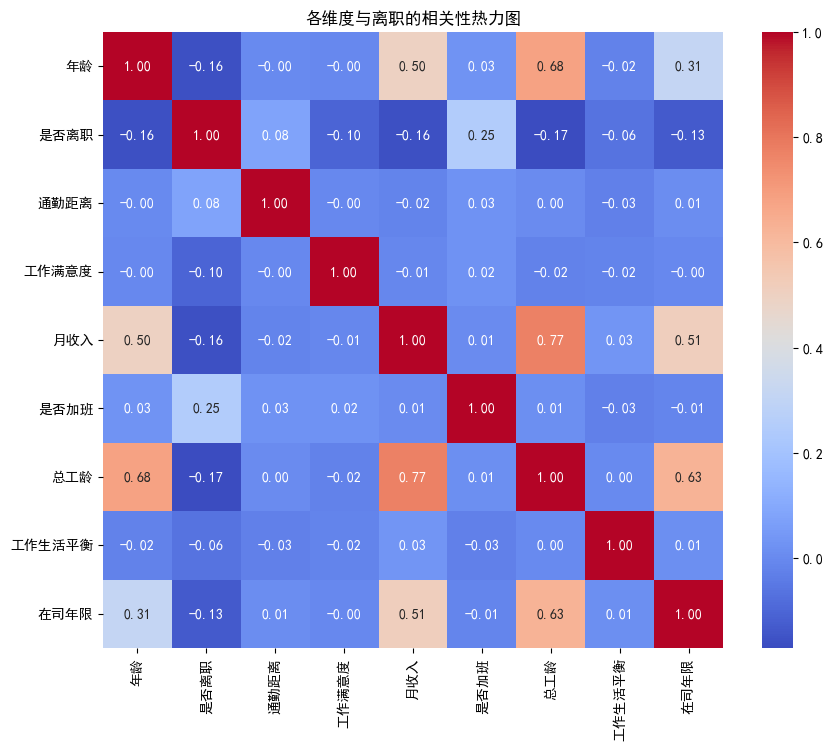

✅ 第四步修正成功：已自动跳过文字列，生成数值相关性热力图！


In [10]:
plt.figure(figsize=(10, 8))

# 核心修正：添加 numeric_only=True，意思是“只计算数值列”
# 这样它就会自动跳过像“出差频率”这种文字列
corr_data = df_clean.corr(numeric_only=True)

# 画图
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('各维度与离职的相关性热力图')
plt.show()

print("✅ 第四步修正成功：已自动跳过文字列，生成数值相关性热力图！")

In [4]:
# 1. 确定 AI 要学习的特征（排除掉“是否离职”本身）
X = df_clean[['年龄', '月收入', '总工龄', '工作满意度', '是否加班', '通勤距离']]
y = df_clean['是否离职']

# 2. 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. 评估结果
y_pred = model.predict(X_test)
print(f"✅ 第四步成功：AI 模型训练完毕！")
print(f"📊 预测准确率: {accuracy_score(y_test, y_pred):.2%}")

# 5. 模拟一个真实场景：
# 一个 25 岁的新人，月薪 3000，工龄 1 年，满意度 2 分，经常加班，住得远（20公里）
test_person = [[25, 3000, 1, 2, 1, 20]]
res = model.predict(test_person)
prob = model.predict_proba(test_person)[0][1]

print("-" * 30)
if res[0] == 1:
    print(f"🔮 AI 预测：该员工【高风险离职】，概率为 {prob:.1%}")
else:
    print(f"🔮 AI 预测：该员工【暂时稳定】，离职概率仅为 {prob:.1%}")

NameError: name 'df_clean' is not defined

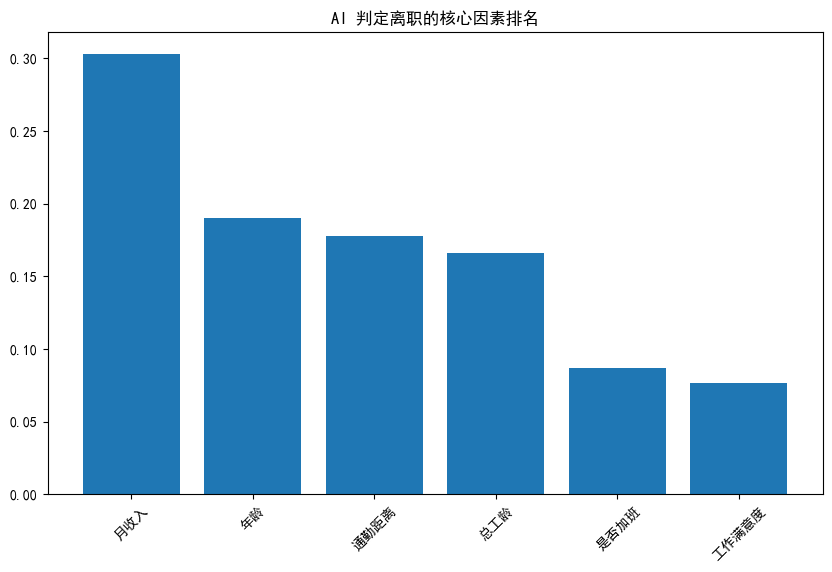

In [12]:
# 查看 AI 认为哪些因素最重要
importances = model.feature_importances_
feat_labels = X.columns

# 排序并画图
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feat_labels[i] for i in indices], rotation=45)
plt.title("AI 判定离职的核心因素排名")
plt.show()

In [13]:
# 如果报错，请在终端执行 pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# 1. 制造“虚构”的离职样本，让数据变成 1:1
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# 2. 用平衡后的数据重新训练模型
model_balanced = RandomForestClassifier(random_state=42)
model_balanced.fit(X_res, y_res)

print("✅ 数据已平衡！现在的 AI 对离职信号会更加敏锐。")

✅ 数据已平衡！现在的 AI 对离职信号会更加敏锐。


C:\Users\tiam\AppData\Local\Temp\ipykernel_34928\1940717077.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='重要程度', y='指标', data=feature_importance_df, palette='viridis')


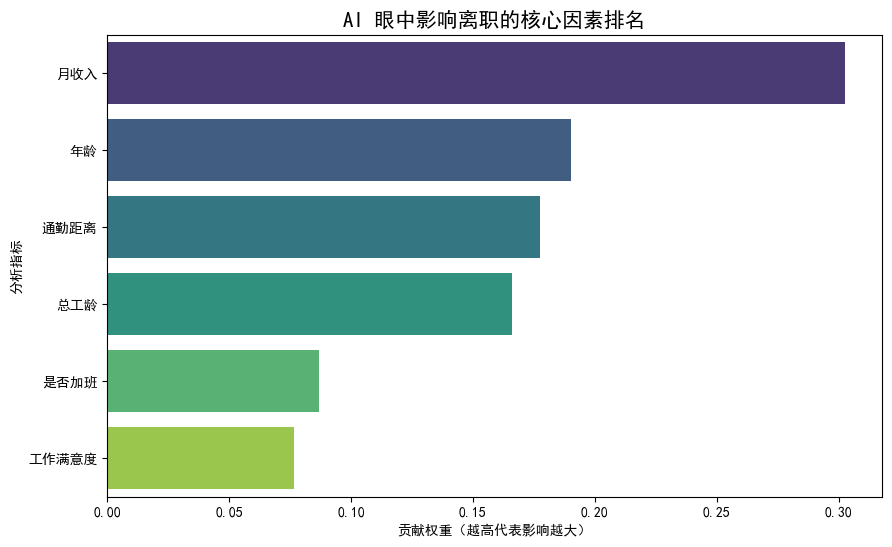

--- AI 的分析结论 ---


,指标,重要程度
1,月收入,0.302725
0,年龄,0.190048
5,通勤距离,0.177599
2,总工龄,0.165878
4,是否加班,0.086927
3,工作满意度,0.076823


In [14]:
# 1. 提取特征重要性
importances = model.feature_importances_
feature_names = X.columns

# 2. 整理成表格，方便查看
feature_importance_df = pd.DataFrame({
    '指标': feature_names,
    '重要程度': importances
}).sort_values(by='重要程度', ascending=False)

# 3. 绘图展示
plt.figure(figsize=(10, 6))
sns.barplot(x='重要程度', y='指标', data=feature_importance_df, palette='viridis')
plt.title('AI 眼中影响离职的核心因素排名', fontsize=15)
plt.xlabel('贡献权重（越高代表影响越大）')
plt.ylabel('分析指标')
plt.show()

print("--- AI 的分析结论 ---")
display(feature_importance_df)

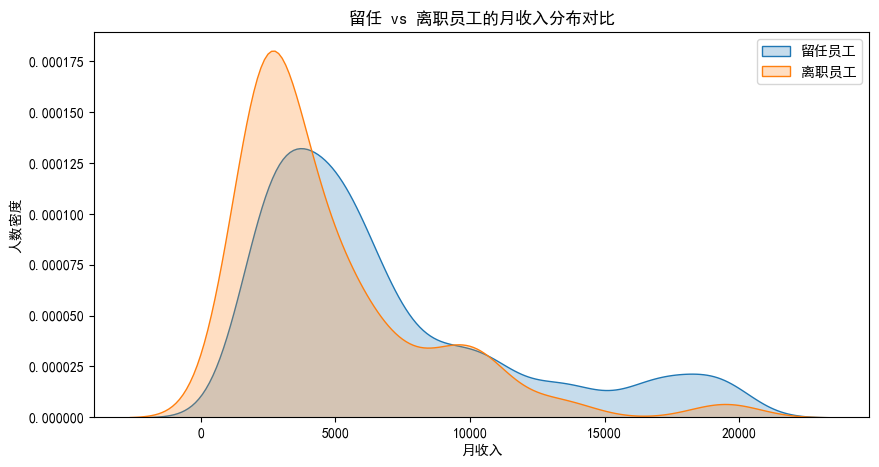

In [15]:
plt.figure(figsize=(10, 5))

# 使用 KDE 分布图看收入密度
sns.kdeplot(df_clean[df_clean['是否离职'] == 0]['月收入'], label='留任员工', fill=True)
sns.kdeplot(df_clean[df_clean['是否离职'] == 1]['月收入'], label='离职员工', fill=True)

plt.title('留任 vs 离职员工的月收入分布对比')
plt.xlabel('月收入')
plt.ylabel('人数密度')
plt.legend()
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# 1. 创建输入组件（滑动条和输入框）
style = {'description_width': 'initial'}
age_sim = widgets.IntSlider(value=30, min=18, max=60, description='年龄:', style=style)
income_sim = widgets.IntSlider(value=5000, min=1000, max=20000, step=100, description='月收入:', style=style)
years_sim = widgets.IntSlider(value=5, min=0, max=40, description='总工龄:', style=style)
sat_sim = widgets.SelectionSlider(options=[1, 2, 3, 4], value=3, description='工作满意度:', style=style)
overtime_sim = widgets.Dropdown(options=[('是', 1), ('否', 0)], value=0, description='是否加班:', style=style)
dist_sim = widgets.IntSlider(value=5, min=1, max=30, description='通勤距离(km):', style=style)

# 2. 创建预测按钮和输出区域
btn = widgets.Button(description="点击预测离职风险", button_style='danger')
out = widgets.Output()

def on_click(b):
    with out:
        out.clear_output()
        # 组装数据 (注意顺序必须和训练时 X 的特征顺序一致)
        # 顺序：'年龄', '月收入', '总工龄', '工作满意度', '是否加班', '通勤距离'
        input_data = [[age_sim.value, income_sim.value, years_sim.value, sat_sim.value, overtime_sim.value, dist_sim.value]]
        
        # 预测
        prob = model.predict_proba(input_data)[0][1]
        
        print(f"--- 预测结果 ---")
        if prob > 0.5:
            print(f"🚨 预警：该员工离职风险高！")
        else:
            print(f"✅ 提示：该员工状态相对稳定。")
        print(f"具体离职概率为: {prob:.1%}")

btn.on_click(on_click)

# 3. 显示界面
print("💡 请调整下方参数并点击预测：")
display(age_sim, income_sim, years_sim, sat_sim, overtime_sim, dist_sim, btn, out)

💡 请调整下方参数并点击预测：


IntSlider(value=30, description='年龄:', max=60, min=18, style=SliderStyle(description_width='initial'))

IntSlider(value=5000, description='月收入:', max=20000, min=1000, step=100, style=SliderStyle(description_width='…

IntSlider(value=5, description='总工龄:', max=40, style=SliderStyle(description_width='initial'))

SelectionSlider(description='工作满意度:', index=2, options=(1, 2, 3, 4), style=DescriptionStyle(description_width=…

Dropdown(description='是否加班:', index=1, options=(('是', 1), ('否', 0)), style=DescriptionStyle(description_width=…

IntSlider(value=5, description='通勤距离(km):', max=30, min=1, style=SliderStyle(description_width='initial'))

Button(button_style='danger', description='点击预测离职风险', style=ButtonStyle())

Output()

In [18]:
# 假设条件：
# 每流失一名员工，招聘和培训新人的成本约为该员工 3 个月的月薪
avg_monthly_income = df_clean['月收入'].mean()
recruitment_cost_per_person = avg_monthly_income * 3

# 假设模型能提前预警并帮助 HR 成功留住 30% 的高风险离职者
predicted_attrition_count = (y_pred == 1).sum() # 测试集中预测离职的人数
saved_count = predicted_attrition_count * 0.3
money_saved = saved_count * recruitment_cost_per_person

print(f"💰 商业价值评估：")
print(f"在测试样本中，模型识别出 {predicted_attrition_count} 名潜在离职员工。")
print(f"如果通过干预留住其中 30% 的人，预估可为公司节省成本: ${money_saved:,.2f}")

💰 商业价值评估：
在测试样本中，模型识别出 11 名潜在离职员工。
如果通过干预留住其中 30% 的人，预估可为公司节省成本: $64,379.02


In [22]:
# 在代码前面加个感弹性感叹号，强制在当前内核安装
!pip install shap

INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.9 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 405.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.8 kB 1.3 MB/s eta 0:00:01
     ------------------------------- ------ 51.2/60.8 kB 871.5 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 803.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   -- ------------------------------------- 30.7/549.3 kB 1.4 MB/s eta 0:00:01
   ----- ----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.2.6 which is incompatible.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.2.6 which is incompatible.
